# EECS 731 Climate Changes

**Author: Likitha Vemulapalli<br>
Date: 11-23-2020 <br>
M.S in Computer Science <br>
University of Kansas**

# Classification of Temperature and Conditions in UK

Classification is a technique where we categorize data into a given number of classes. The main goal of a classification problem is to identify the class to which a new data will fall under <br>

Classifier: An algorithm that maps the input data to a specific category

Here, we used classification to predict the Temperature and Conditions in United Kingdom. 

# Importing Libraries

In [1]:
#importing required libraries
import pandas as pd
import numpy as np

#For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#For Cross-Validation
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

#For Classifier models
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron

# Importing the data

In [2]:
df = pd.read_csv('UK_data.csv')
df.head()

,Name,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow Depth,Wind Speed,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
0,uk,01/01/1973,44.6,30.3,40.4,30.9,NaN,0.00,NaN,11.3,NaN,1.6,65.2,87.83,Partially cloudy
1,uk,01/02/1973,46.5,31.3,41.8,33.1,NaN,0.01,NaN,11.4,NaN,2.0,51.7,87.27,"Rain, Partially cloudy"
2,uk,01/03/1973,53.6,46.4,49.6,41.2,NaN,0.00,NaN,11.4,NaN,5.4,90.5,84.87,Overcast
3,uk,01/04/1973,51.9,45.7,50.4,47.4,NaN,0.00,0.0,5.6,NaN,1.3,97.5,90.75,Overcast
4,uk,01/05/1973,48.3,39.3,43.7,33.3,NaN,0.00,NaN,14.9,NaN,3.9,77.8,81.33,Overcast


In [3]:
#dropping the columns that are not required for classification
df = df.drop(columns = ['Name', 'Date time'])

In [4]:
df.head()

,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow Depth,Wind Speed,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
0,44.6,30.3,40.4,30.9,NaN,0.00,NaN,11.3,NaN,1.6,65.2,87.83,Partially cloudy
1,46.5,31.3,41.8,33.1,NaN,0.01,NaN,11.4,NaN,2.0,51.7,87.27,"Rain, Partially cloudy"
2,53.6,46.4,49.6,41.2,NaN,0.00,NaN,11.4,NaN,5.4,90.5,84.87,Overcast
3,51.9,45.7,50.4,47.4,NaN,0.00,0.0,5.6,NaN,1.3,97.5,90.75,Overcast
4,48.3,39.3,43.7,33.3,NaN,0.00,NaN,14.9,NaN,3.9,77.8,81.33,Overcast


In [5]:
#checking for the null values
df.isnull().sum()

Maximum Temperature        0
Minimum Temperature        0
Temperature                0
Wind Chill              8250
Heat Index             16927
Precipitation              0
Snow Depth             16662
Wind Speed                 0
Wind Gust              16218
Visibility                 0
Cloud Cover                1
Relative Humidity          0
Conditions                 0
dtype: int64

Note: As we have huge number of null values in Wind Chill, Heat Index, Snow Depth and Wind Gust we are dropping these columns

In [6]:
#removing columns with most null values
df = df.drop(columns = ['Wind Chill', 'Heat Index', 'Snow Depth', 'Wind Gust'])

In [7]:
df.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions
0,44.6,30.3,40.4,0.00,11.3,1.6,65.2,87.83,Partially cloudy
1,46.5,31.3,41.8,0.01,11.4,2.0,51.7,87.27,"Rain, Partially cloudy"
2,53.6,46.4,49.6,0.00,11.4,5.4,90.5,84.87,Overcast
3,51.9,45.7,50.4,0.00,5.6,1.3,97.5,90.75,Overcast
4,48.3,39.3,43.7,0.00,14.9,3.9,77.8,81.33,Overcast


To remove the redundancy in the Conditions, I seperated the text based on the comma and created new column to predict the Conditions

In [8]:
df["Conditions"]= df["Conditions"].str.split(",", n = 1, expand = True) 

In [9]:
df.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions
0,44.6,30.3,40.4,0.00,11.3,1.6,65.2,87.83,Partially cloudy
1,46.5,31.3,41.8,0.01,11.4,2.0,51.7,87.27,Rain
2,53.6,46.4,49.6,0.00,11.4,5.4,90.5,84.87,Overcast
3,51.9,45.7,50.4,0.00,5.6,1.3,97.5,90.75,Overcast
4,48.3,39.3,43.7,0.00,14.9,3.9,77.8,81.33,Overcast


In [10]:
#checking for the null values
df.isnull().sum()

Maximum Temperature    0
Minimum Temperature    0
Temperature            0
Precipitation          0
Wind Speed             0
Visibility             0
Cloud Cover            1
Relative Humidity      0
Conditions             0
dtype: int64

In [11]:
# Filling the null value in Cloud Cover
df = df.apply(lambda x : x.fillna(method = 'ffill', axis=0))

In [12]:
#checking for the null values
df.isnull().sum()

Maximum Temperature    0
Minimum Temperature    0
Temperature            0
Precipitation          0
Wind Speed             0
Visibility             0
Cloud Cover            0
Relative Humidity      0
Conditions             0
dtype: int64

In [13]:
#For classification, categorizing the temperature data into 3 categories
tg_labels = [1,2,3]
df['UK_Temp_bins'] = pd.cut(df['Temperature'], 3, labels=tg_labels, include_lowest=True)

df_temp = df[['Maximum Temperature', 'Minimum Temperature', 'Temperature', 'Precipitation', 'Wind Speed', 'Visibility', 'Cloud Cover', 'Relative Humidity',  'UK_Temp_bins']]

df_temp.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Visibility,Cloud Cover,Relative Humidity,UK_Temp_bins
0,44.6,30.3,40.4,0.00,11.3,1.6,65.2,87.83,1
1,46.5,31.3,41.8,0.01,11.4,2.0,51.7,87.27,2
2,53.6,46.4,49.6,0.00,11.4,5.4,90.5,84.87,2
3,51.9,45.7,50.4,0.00,5.6,1.3,97.5,90.75,2
4,48.3,39.3,43.7,0.00,14.9,3.9,77.8,81.33,2


Temperature is running value, so I splitted the temperature into three Classes - low, medium and high.

In [14]:
#low = (19.936, 41.5]
#medium = (41.5, 63.0]
#high = (63.0, 84.5]

pd.cut(df['Temperature'], 3).head()

0    (19.936, 41.5]
1      (41.5, 63.0]
2      (41.5, 63.0]
3      (41.5, 63.0]
4      (41.5, 63.0]
Name: Temperature, dtype: category
Categories (3, interval[float64]): [(19.936, 41.5] < (41.5, 63.0] < (63.0, 84.5]]

In [15]:
df_temp.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Visibility,Cloud Cover,Relative Humidity,UK_Temp_bins
0,44.6,30.3,40.4,0.00,11.3,1.6,65.2,87.83,1
1,46.5,31.3,41.8,0.01,11.4,2.0,51.7,87.27,2
2,53.6,46.4,49.6,0.00,11.4,5.4,90.5,84.87,2
3,51.9,45.7,50.4,0.00,5.6,1.3,97.5,90.75,2
4,48.3,39.3,43.7,0.00,14.9,3.9,77.8,81.33,2


In [16]:
df_temp.shape

(17472, 9)

In [17]:
df_temp.isnull().sum()

Maximum Temperature    0
Minimum Temperature    0
Temperature            0
Precipitation          0
Wind Speed             0
Visibility             0
Cloud Cover            0
Relative Humidity      0
UK_Temp_bins           0
dtype: int64

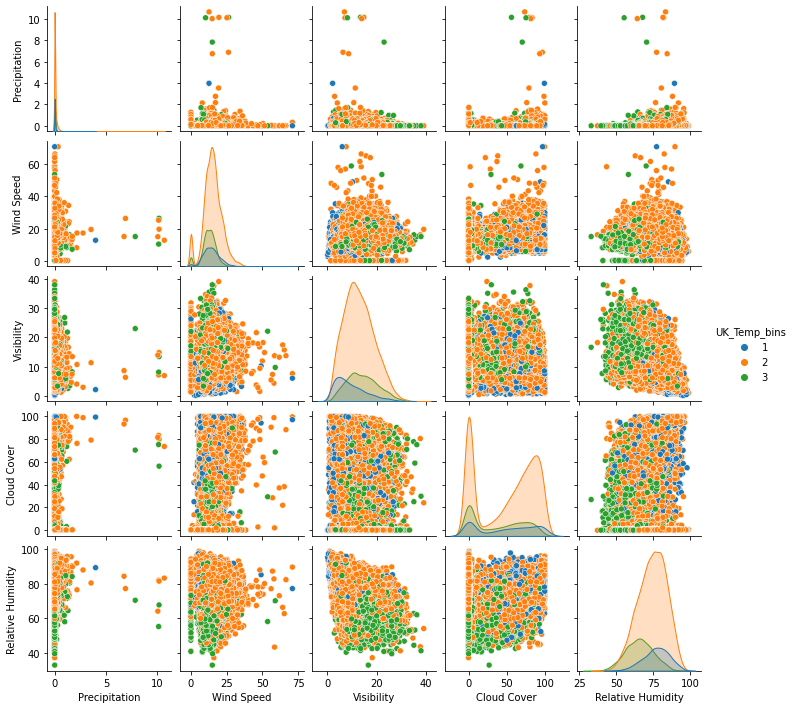

In [18]:
# Pair plot to get the distributions of temp_bins
pair_plot = sns.pairplot(df_temp, hue='UK_Temp_bins',vars=['Precipitation','Wind Speed','Visibility','Cloud Cover','Relative Humidity'], height=2)

Pair plots are simple way to visualize relationships between each variable.<br>
Here, we could see that precipitation has nothing much to do with temperature, we can drop  that column as it doesn't show much affect

# Classification of Temperature

In [19]:
df_temp.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Visibility,Cloud Cover,Relative Humidity,UK_Temp_bins
0,44.6,30.3,40.4,0.00,11.3,1.6,65.2,87.83,1
1,46.5,31.3,41.8,0.01,11.4,2.0,51.7,87.27,2
2,53.6,46.4,49.6,0.00,11.4,5.4,90.5,84.87,2
3,51.9,45.7,50.4,0.00,5.6,1.3,97.5,90.75,2
4,48.3,39.3,43.7,0.00,14.9,3.9,77.8,81.33,2


In [20]:
#removing columns which are not required
df_temp = df_temp.drop(columns = ['Maximum Temperature', 'Minimum Temperature', 'Temperature', 'Precipitation'])

In [21]:
df_temp.head()

,Wind Speed,Visibility,Cloud Cover,Relative Humidity,UK_Temp_bins
0,11.3,1.6,65.2,87.83,1
1,11.4,2.0,51.7,87.27,2
2,11.4,5.4,90.5,84.87,2
3,5.6,1.3,97.5,90.75,2
4,14.9,3.9,77.8,81.33,2


For using cross validation, we divide the data into arrays specifically X having the features and y being the temperature column.

In [22]:
# Split-out dataset
array = df_temp.values
X = array[:,0:4]
print(X)
y = array[:,4]
print(y)


[[11.3   1.6  65.2  87.83]
 [11.4   2.   51.7  87.27]
 [11.4   5.4  90.5  84.87]
 ...
 [20.3   6.   89.4  81.07]
 [26.6   6.1  73.5  69.64]
 [21.    6.1  66.4  74.4 ]]
[1. 2. 2. ... 2. 2. 2.]


In [23]:
# Using 10 fold cross validation

kf = KFold(n_splits=10, random_state=None, shuffle=False)

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [25]:
#1. Linear SVM

ypred_outputs_SVC = []
yrandom_outputs_SVC = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = SVC(kernel='linear')
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_SVC.append(ypred)
    yrandom_outputs_SVC.append(ytest)

pSVCtotal = np.concatenate(ypred_outputs_SVC)
ySVCtotal = np.concatenate(yrandom_outputs_SVC)


acc_svc = round((accuracy_score(ySVCtotal, pSVCtotal)*100), 2)

print('Accuracy for SVC:', acc_svc)

Accuracy for SVC: 70.41


In [26]:
#2. Decision Tree Classifier

ypred_outputs_DT = []
yrandom_outputs_DT = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = tree.DecisionTreeClassifier()
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_DT.append(ypred)
    yrandom_outputs_DT.append(ytest)

pDTtotal = np.concatenate(ypred_outputs_DT)
yDTtotal = np.concatenate(yrandom_outputs_DT)


acc_dt = round((accuracy_score(yDTtotal, pDTtotal)*100), 2)

print('Accuracy for Decision Tree Classifier:', acc_dt)

Accuracy for Decision Tree Classifier: 57.92


In [27]:
#3. KNN Classifier

ypred_outputs_KNN = []
yrandom_outputs_KNN = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = KNeighborsClassifier(n_neighbors = 12)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_KNN.append(ypred)
    yrandom_outputs_KNN.append(ytest)

pKNNtotal = np.concatenate(ypred_outputs_KNN)
yKNNtotal = np.concatenate(yrandom_outputs_KNN)


acc_knn = round((accuracy_score(yKNNtotal, pKNNtotal)*100), 2)

print('Accuracy for KNN Classifier:', acc_knn)

Accuracy for KNN Classifier: 69.18


In [28]:
#4. Random Forest Classifier

ypred_outputs_RF = []
yrandom_outputs_RF = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = RandomForestClassifier(n_estimators=100)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_RF.append(ypred)
    yrandom_outputs_RF.append(ytest)

pRFtotal = np.concatenate(ypred_outputs_RF)
yRFtotal = np.concatenate(yrandom_outputs_RF)


acc_rf = round((accuracy_score(yRFtotal, pRFtotal)*100), 2)

print('Accuracy for Random Forest Classifier:', acc_rf)

Accuracy for Random Forest Classifier: 68.21


In [29]:
#5. Gaussian NB

ypred_outputs_NBC = []
yrandom_outputs_NBC = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = GaussianNB()
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_NBC.append(ypred)
    yrandom_outputs_NBC.append(ytest)

pNBCtotal = np.concatenate(ypred_outputs_NBC)
yNBCtotal = np.concatenate(yrandom_outputs_NBC)


acc_gaussian = round((accuracy_score(yNBCtotal, pNBCtotal)*100), 2)

print('Accuracy for Gaussian NB:', acc_gaussian)

Accuracy for Gaussian NB: 69.71


In [30]:
#6. Perceptron

ypred_outputs_perceptron = []
yrandom_outputs_perceptron = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = Perceptron()
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_perceptron.append(ypred)
    yrandom_outputs_perceptron.append(ytest)

pPerceptrontotal = np.concatenate(ypred_outputs_perceptron)
yPerceptrontotal = np.concatenate(yrandom_outputs_perceptron)


acc_perceptron = round((accuracy_score(yPerceptrontotal, pPerceptrontotal)*100), 2)

print('Accuracy for Perceptron:', acc_perceptron)

Accuracy for Perceptron: 46.35


In [31]:
#Comparing models to get the best suitable model

In [32]:
models = pd.DataFrame({
    'Model': ['Linear SVC', 'Decision Tree','KNN', 'Random Forest', 'Gaussian Naive Bayes'],
    'Accuracy': [acc_svc, acc_dt, acc_knn, acc_rf, acc_gaussian]})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
0,Linear SVC,70.41
4,Gaussian Naive Bayes,69.71
2,KNN,69.18
3,Random Forest,68.21
1,Decision Tree,57.92


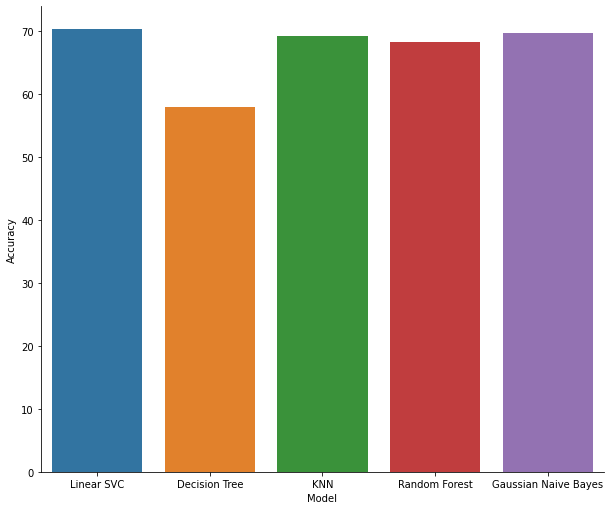

In [33]:
sns.catplot(data=models, y='Accuracy',x='Model',kind='bar',height=7,aspect=1.2)

On comparing models, we observe that Linear SVC performed well rather than other models. There was not huge difference between Gaussian, KNN when compared with Linear SVM.

# Classification of Conditions

In [34]:
df_conditions = df.copy(deep=True)

In [35]:
df_conditions.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions,UK_Temp_bins
0,44.6,30.3,40.4,0.00,11.3,1.6,65.2,87.83,Partially cloudy,1
1,46.5,31.3,41.8,0.01,11.4,2.0,51.7,87.27,Rain,2
2,53.6,46.4,49.6,0.00,11.4,5.4,90.5,84.87,Overcast,2
3,51.9,45.7,50.4,0.00,5.6,1.3,97.5,90.75,Overcast,2
4,48.3,39.3,43.7,0.00,14.9,3.9,77.8,81.33,Overcast,2


In [36]:
#removing columns which are not required
df_conditions = df_conditions.drop(columns = ['Maximum Temperature', 'Minimum Temperature', 'UK_Temp_bins'])

In [37]:
df_conditions.shape

(17472, 7)

In [38]:
df_conditions.isnull().sum()

Temperature          0
Precipitation        0
Wind Speed           0
Visibility           0
Cloud Cover          0
Relative Humidity    0
Conditions           0
dtype: int64

In [39]:
df_conditions.describe()

,Temperature,Precipitation,Wind Speed,Visibility,Cloud Cover,Relative Humidity
count,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000
mean,53.325429,0.058207,14.571646,12.629064,47.432647,72.879092
std,9.684888,0.250774,6.341496,6.242225,36.815400,10.108126
min,20.000000,0.000000,0.000000,0.100000,0.000000,33.030000
25%,46.100000,0.000000,11.200000,7.900000,0.400000,65.770000
50%,53.100000,0.000000,14.050000,12.000000,56.500000,73.520000
75%,60.800000,0.040000,18.300000,16.900000,81.200000,80.500000
max,84.500000,10.670000,71.000000,39.100000,100.000000,98.840000


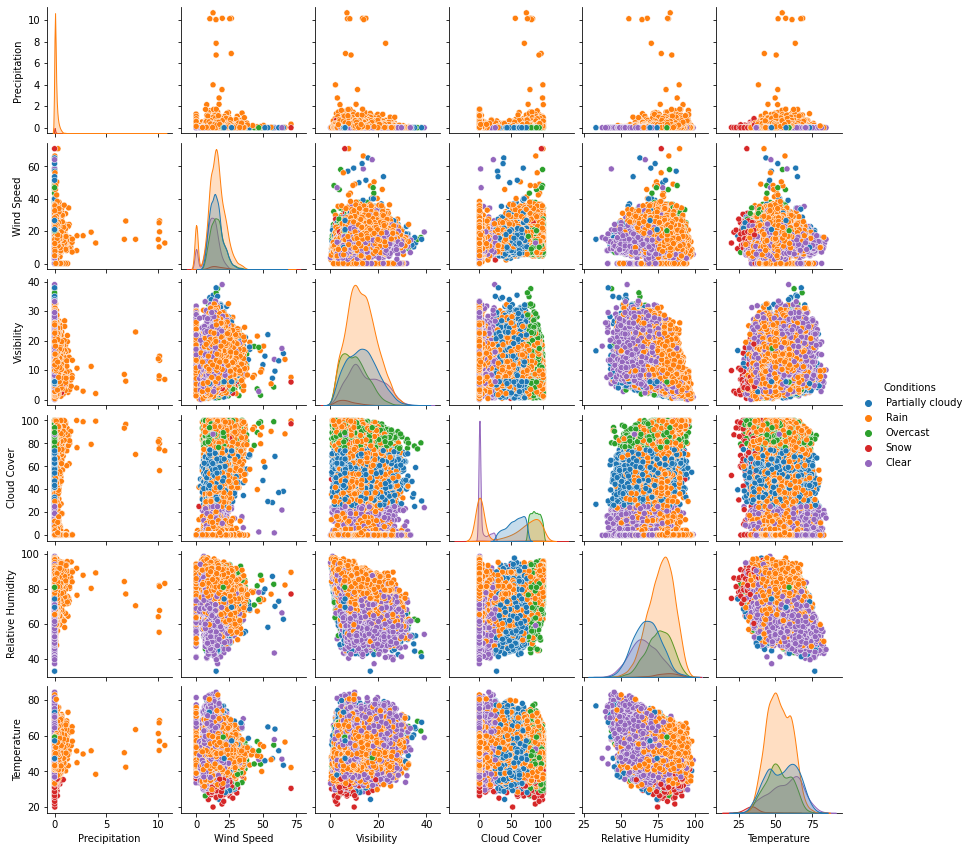

In [40]:
# Pair plot to get the distributions of Conditions
import warnings
warnings.simplefilter('ignore')
pair_plot = sns.pairplot(df_conditions, hue='Conditions',vars=['Precipitation', 'Wind Speed','Visibility','Cloud Cover','Relative Humidity', 'Temperature'], height=2)

When you observe the plot, precipitation shows slight variation unlike when considered for temperature. So, we will use that feature for classifying conditions.

In [41]:
df_conditions.head()

,Temperature,Precipitation,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions
0,40.4,0.00,11.3,1.6,65.2,87.83,Partially cloudy
1,41.8,0.01,11.4,2.0,51.7,87.27,Rain
2,49.6,0.00,11.4,5.4,90.5,84.87,Overcast
3,50.4,0.00,5.6,1.3,97.5,90.75,Overcast
4,43.7,0.00,14.9,3.9,77.8,81.33,Overcast


For using cross validation, we divide the data into arrays specifically X having the features and y being the temperature column.

In [42]:
# Split-out dataset
array = df_conditions.values
X = array[:,0:6]
print(X)
y = array[:,6]
print(y)


[[40.4 0.0 11.3 1.6 65.2 87.83]
 [41.8 0.01 11.4 2.0 51.7 87.27]
 [49.6 0.0 11.4 5.4 90.5 84.87]
 ...
 [59.3 0.0 20.3 6.0 89.4 81.07]
 [57.2 0.0 26.6 6.1 73.5 69.64]
 [47.3 0.0 21.0 6.1 66.4 74.4]]
['Partially cloudy' 'Rain' 'Overcast' ... 'Overcast' 'Partially cloudy'
 'Partially cloudy']


In [43]:
# 10 fold cross validation

kf = KFold(n_splits=10, random_state=None, shuffle=False)

In [44]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [45]:
#1. Linear SVM

ypred_outputs_SVC = []
yrandom_outputs_SVC = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = SVC(kernel='linear')
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_SVC.append(ypred)
    yrandom_outputs_SVC.append(ytest)

pSVCtotal = np.concatenate(ypred_outputs_SVC)
ySVCtotal = np.concatenate(yrandom_outputs_SVC)


acc_svc = round((accuracy_score(ySVCtotal, pSVCtotal)*100), 2)

print('Accuracy for SVC:', acc_svc)

Accuracy for SVC: 63.76


In [46]:
#2. Decision Tree Classifier

ypred_outputs_DT = []
yrandom_outputs_DT = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = tree.DecisionTreeClassifier()
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_DT.append(ypred)
    yrandom_outputs_DT.append(ytest)

pDTtotal = np.concatenate(ypred_outputs_DT)
yDTtotal = np.concatenate(yrandom_outputs_DT)


acc_dt = round((accuracy_score(yDTtotal, pDTtotal)*100), 2)

print('Accuracy for Decision Tree Classifier:', acc_dt)

Accuracy for Decision Tree Classifier: 98.23


In [47]:
#3. KNN Classifier

ypred_outputs_KNN = []
yrandom_outputs_KNN = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = KNeighborsClassifier(n_neighbors = 5)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_KNN.append(ypred)
    yrandom_outputs_KNN.append(ytest)

pKNNtotal = np.concatenate(ypred_outputs_KNN)
yKNNtotal = np.concatenate(yrandom_outputs_KNN)


acc_knn = round((accuracy_score(yKNNtotal, pKNNtotal)*100), 2)

print('Accuracy for KNN Classifier:', acc_knn)

Accuracy for KNN Classifier: 65.13


In [48]:
#4. Random Forest Classifier

ypred_outputs_RF = []
yrandom_outputs_RF = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = RandomForestClassifier(n_estimators=100)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_RF.append(ypred)
    yrandom_outputs_RF.append(ytest)

pRFtotal = np.concatenate(ypred_outputs_RF)
yRFtotal = np.concatenate(yrandom_outputs_RF)


acc_rf = round((accuracy_score(yRFtotal, pRFtotal)*100), 2)

print('Accuracy for Random Forest Classifier:', acc_rf)

Accuracy for Random Forest Classifier: 98.92


In [49]:
#5. Gaussian NB

ypred_outputs_NBC = []
yrandom_outputs_NBC = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = GaussianNB()
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_NBC.append(ypred)
    yrandom_outputs_NBC.append(ytest)

pNBCtotal = np.concatenate(ypred_outputs_NBC)
yNBCtotal = np.concatenate(yrandom_outputs_NBC)


acc_gaussian = round((accuracy_score(yNBCtotal, pNBCtotal)*100), 2)

print('Accuracy for Gaussian NB:', acc_gaussian)

Accuracy for Gaussian NB: 95.19


In [50]:
#Comparing models to get the best suitable model

In [53]:
models = pd.DataFrame({
    'Model': ['Linear SVC', 'Decision Tree','KNN', 'Random Forest', 'Gaussian Naive Bayes'],
    'Accuracy': [acc_svc, acc_dt, acc_knn, acc_rf, acc_gaussian]})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
3,Random Forest,98.92
1,Decision Tree,98.23
4,Gaussian Naive Bayes,95.19
2,KNN,65.13
0,Linear SVC,63.76


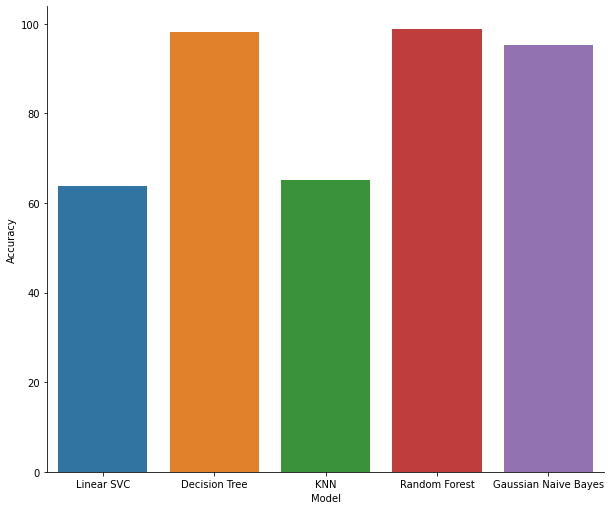

In [54]:
sns.catplot(data=models, y='Accuracy',x='Model',kind='bar',height=7,aspect=1.2)

We can see clearly that Decision Tree and Random Forest Classifiers performed pretty good on predicting the test data accurately.